<a href="https://colab.research.google.com/github/Weverton-Vitor/multiclass-semantic-segmentation-unet/blob/main/cityscapes_pytorch_unet_multiclass_segmentation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiclass Semantic Segmentation: CityScape

## 1. Imports Libs and mount the drive


In [76]:
import os
import zipfile
import glob

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from PIL import Image

## 2. Get and preprocessing the Dataset

To get the data we need to login into Cityscapes site, once you have create your acount your can run the next cells to login into cityscapes and get the selected dataset, they have a lot of datasets, for this experiment we'll use the dataset describe below:

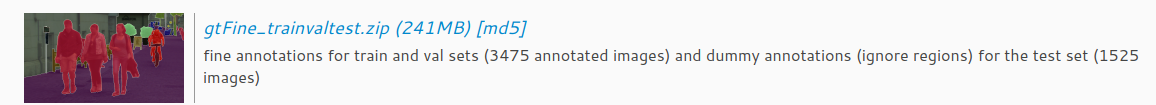

> Note: they also have an API that you can install using pip, if you want to dive deeper into this, the document is on GitHub: [Citysacepes Scripts](https://github.com/mcordts/cityscapesScripts)

In [27]:
# Login into cityscapes site and keep the cookies
username = ''
password = ''
command = f"wget --keep-session-cookies --save-cookies=cookies.txt --post-data 'username={username}&password={password}&submit=Login' https://www.cityscapes-dataset.com/login/"
!{command}

--2024-03-25 23:46:37--  https://www.cityscapes-dataset.com/login/
Resolving www.cityscapes-dataset.com (www.cityscapes-dataset.com)... 139.19.217.8
Connecting to www.cityscapes-dataset.com (www.cityscapes-dataset.com)|139.19.217.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.cityscapes-dataset.com/downloads/ [following]
--2024-03-25 23:46:38--  https://www.cityscapes-dataset.com/downloads/
Reusing existing connection to www.cityscapes-dataset.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘index.html.1’

index.html.1            [  <=>               ]  57.34K   241KB/s    in 0.2s    

2024-03-25 23:46:39 (241 KB/s) - ‘index.html.1’ saved [58715]



In [28]:
# Using the cookies to keep the session and donwload the data
!wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=3

--2024-03-25 23:46:40--  https://www.cityscapes-dataset.com/file-handling/?packageID=3
Resolving www.cityscapes-dataset.com (www.cityscapes-dataset.com)... 139.19.217.8
Connecting to www.cityscapes-dataset.com (www.cityscapes-dataset.com)|139.19.217.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11592327197 (11G) [application/octet-stream]
Saving to: ‘leftImg8bit_trainvaltest.zip’

leftImg8bit_trainva 100%[===================>]  10.80G  24.6MB/s    in 7m 44s  

2024-03-25 23:54:25 (23.8 MB/s) - ‘leftImg8bit_trainvaltest.zip’ saved [11592327197/11592327197]



In [8]:
# Download the annotations
!wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=1

--2024-03-25 22:44:42--  https://www.cityscapes-dataset.com/file-handling/?packageID=1
Resolving www.cityscapes-dataset.com (www.cityscapes-dataset.com)... 139.19.217.8
Connecting to www.cityscapes-dataset.com (www.cityscapes-dataset.com)|139.19.217.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252567705 (241M) [application/octet-stream]
Saving to: ‘gtFine_trainvaltest.zip.1’

gtFine_trainvaltest 100%[===================>] 240.87M  24.5MB/s    in 11s     

2024-03-25 22:44:53 (22.6 MB/s) - ‘gtFine_trainvaltest.zip.1’ saved [252567705/252567705]



In [11]:
# Delete cookies file for security
!rm /content/cookies.txt

In [29]:
with zipfile.ZipFile('/content/leftImg8bit_trainvaltest.zip') as file:
  file.extractall('./')

In [12]:
# Unzip the data
with zipfile.ZipFile('/content/gtFine_trainvaltest.zip') as file:
  file.extractall('./')

In [37]:
train_path = '/content/leftImg8bit/train'
val_path = '/content/leftImg8bit/val'
test_path = '/content/leftImg8bit/test'

train_anns = '/content/gtFine/train'
val_anns = '/content/gtFine/val'
test_anns = '/content/gtFine/test'

files = glob.glob('*.txt')
print(f'Number of train samples: {len(glob.glob(train_path + "/*/*.png"))}')
print(f'Number of validation samples: {len(glob.glob(val_path + "/*/*.png"))}')
print(f'Number of test samples: {len(glob.glob(test_path + "/*/*.png"))}')

Number of train samples: 2975
Number of validation samples: 500
Number of test samples: 1525


### 2.1 Create Dataset Class

In [103]:
class CityscapesDataset(Dataset):
  __default_transform = transforms.Compose([transforms.ToTensor()])

  def __init__(self,
               data_path: str,
               anns_path: str,
               gray_scale_masks=False,
               transformer: transforms.Compose=__default_transform,
               label_transformer: transforms.Compose=__default_transform):

    super().__init__()
    self.data_path = data_path
    self.anns_path = anns_path
    self.transformer = transformer
    self.label_transformer = label_transformer
    self.images = glob.glob(self.data_path + "/*/*.png")
    self.anns = glob.glob(self.anns_path + "/*/*_gtFine_color.png")

  def __len__(self):
    return len(self.images)


  def __getitem__(self, index) -> tuple:
    # Get the path os the mask
    image_name = self.images[index].split('/')[-1]
    mask_path = list(filter(lambda x: x.split('/')[-1].split('_gtFine_color')[0] in image_name, self.anns))[0]

    # Open and transform the selexted image
    image = Image.open(self.images[index])
    image = self.transformer(image)

    # Do the same to the mask
    mask = Image.open(mask_path)
    mask = self.label_transformer(mask)

    return image, mask





In [104]:
test = CityscapesDataset(data_path=train_path,
                         anns_path=train_anns)
a, b = test[1]
len(test)

2975

In [100]:
a

tensor([[[0.0863, 0.0824, 0.0863,  ..., 0.3451, 0.3451, 0.3529],
         [0.0941, 0.0941, 0.0941,  ..., 0.3412, 0.3451, 0.3490],
         [0.1020, 0.1020, 0.1020,  ..., 0.3451, 0.3490, 0.3490],
         ...,
         [0.0902, 0.0863, 0.0863,  ..., 0.0902, 0.0824, 0.0824],
         [0.0902, 0.0863, 0.0863,  ..., 0.1020, 0.0980, 0.0941],
         [0.0902, 0.0863, 0.0863,  ..., 0.0980, 0.0980, 0.0980]],

        [[0.1176, 0.1176, 0.1216,  ..., 0.4157, 0.4157, 0.4196],
         [0.1294, 0.1294, 0.1294,  ..., 0.4157, 0.4157, 0.4196],
         [0.1412, 0.1412, 0.1412,  ..., 0.4196, 0.4196, 0.4196],
         ...,
         [0.1373, 0.1373, 0.1373,  ..., 0.1451, 0.1373, 0.1412],
         [0.1373, 0.1373, 0.1373,  ..., 0.1608, 0.1529, 0.1490],
         [0.1373, 0.1373, 0.1373,  ..., 0.1569, 0.1529, 0.1529]],

        [[0.0745, 0.0745, 0.0784,  ..., 0.3451, 0.3451, 0.3412],
         [0.0863, 0.0863, 0.0902,  ..., 0.3451, 0.3451, 0.3373],
         [0.0902, 0.0863, 0.0941,  ..., 0.3451, 0.3451, 0.

In [102]:
b

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 

### 2.1 View random samples

### 2.2 View random masks

### 2.3 Visualizing images with its mask